# SEL634 - Laboratório de Robôs Manipuladores

## Inicialização da biblioteca

Carregar a biblioteca de robótica para Python:

In [1]:
!python3 -m pip install --user --upgrade pip==20.1
!pip install roboticstoolbox-python
!pip install spatialmath-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 33.6 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pip-tools 6.2.0 requires pip>=20.3, but you have pip 20.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 21.8 MB/s 
     |████████████████████████████████| 178 kB 17.5 MB/s 
     |████████████████████████████████| 112.2 MB 104 kB/s 
     |████████████████████████████████| 1.5 MB 48.1 MB/s 
     |████████████████████████████████| 13.5 MB 44.5 MB/s 
     |████████████████████████████████| 112 kB 64.0 MB/s 
  Created wheel for p

In [2]:
import numpy as np
#import roboticstoolbox as rtb
from roboticstoolbox import *
from spatialmath import *
from spatialmath.base import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
#np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})
from mpl_toolkits import mplot3d

# no Binder utilizar essa linha
# %matplotlib notebook  
# no Colab utilizar essa linha
%matplotlib inline

## Cinemática Direta do Robô Kinova Gen3

O robô Kinova Gen3 pode ser modelado pela seguinte função (ver Tarefa 2):

In [3]:
def kinova_robot(my_name):
  robot = DHRobot(
      [
       # Colocar seu código aqui para completar a descrição do robô
        RevoluteDH(d=-(0.1564+0.1284), alpha=pi/2),
            RevoluteDH(d=-(0.0054+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2104+0.2104), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.0064+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2084+0.1059), alpha=pi/2, offset=pi),
            RevoluteDH(alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.1059+0.0615), alpha=pi, offset=pi)
       ], name=my_name)
  H_B0 = SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi)
  robot.base = H_B0
  return robot


A pose do efetuador do robô Kinova Gen3 é dada em relação a base, $B$, pela função:

In [4]:
def pose_efetuador(robot, q):
  H_B7 = robot.fkine(q)
  return H_B7

## Trajetória do Robô no Espaço das Juntas

Considere que a junta $i$ possui a seguinte trajetória  em graus no tempo que leva a junta $i$ da posição $\theta_{si}$ até $\theta_{gi}$ em um dado tempo $T_d$:
$$ \theta_i (t) = c_{0i} + c_{1i} t + c_{2i} t^2 + c_{3i} t^3 + c_{4i} t^4 + c_{5i} t^5 $$
Para velocidades e acelerações iniciais e finais iguais a zero, os coeficientes do polinômio são dados em função da posição inicial e final e do intervalo de tempo:
\begin{eqnarray*}
	&c_{0i}& = \theta_{si}\\
	&c_{1i}& = c_{2i} = 0\\
	&c_{3i}& = \frac{10(\theta_{gi}-\theta_{si})}{T_d^{3}}\\
	&c_{4i}& = \frac{15(\theta_{si}-\theta_{gi})}{T_d^{4}}\\
	&c_{5i}& = \frac{6(\theta_{gi}-\theta_{si})}{T_d^{5}}
\end{eqnarray*}

A velocidade de cada junta para condições iniciais nulas é dada por:
$$ \dot\theta_i (t) = c_{1i} + 2c_{2i} t + 3c_{3i} t^2 + 4c_{4i} t^3 + 5c_{5i} t^4 $$

A aceleração de cada junta para condições iniciais nulas é dada por:
$$ \ddot\theta_i (t) = 2c_{2i} + 6c_{3i} t + 12c_{4i} t^2 + 20c_{5i} t^3 $$

A função a seguir foi implementada na Tarefa 3 para calcular a trajetória das juntas do manipulador:


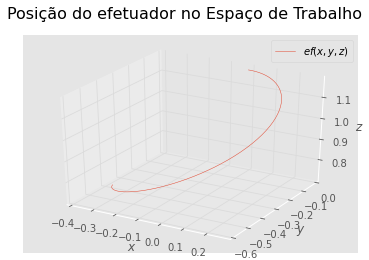

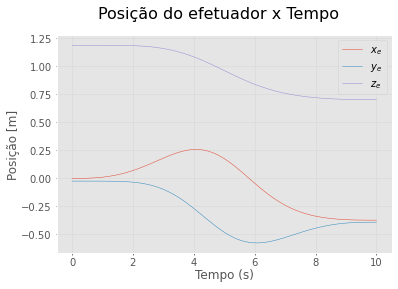

In [17]:
def calcular_trajetoria(theta_s, theta_g, Td, dt):
  # Coloque seu codigo aqui
    N = theta_s.size # Array length
    
    c0 = theta_s
    c1 = np.zeros(N)
    c2 = c1
    c3 = 10*(theta_g-theta_s)/Td**3
    c4 = 15*(theta_s-theta_g)/Td**4
    c5 = 6*(theta_g-theta_s)/Td**5
    
    #print(c1)

    start = 0
    step = dt
    end = Td+step
    t = np.arange(start,end,step)
    t2 = np.power(t,2)
    t3 = np.power(t,3)
    t4 = np.power(t,4)
    t5 = np.power(t,5)
    
    M = len(t) # Number of points used in the trajectory discretization
    #print(c3)

    #here adjust MxN dimensions 
    # https://numpy.org/doc/stable/user/basics.broadcasting.html
    # https://numpy.org/doc/stable/reference/generated/numpy.tile.html?highlight=numpy%20tile#numpy.tile
    
    tVec = np.transpose(np.tile(t,(N,1)))
    tVec2 = np.transpose(np.tile(t2,(N,1)))
    tVec3 = np.transpose(np.tile(t3,(N,1)))
    tVec4 = np.transpose(np.tile(t4,(N,1)))
    tVec5 = np.transpose(np.tile(t5,(N,1)))
    
    onesVec = np.ones((M,N))
    
    #print(tVec2)
    #print("M =",M)
    #print(tVec*c1[np.newaxis,:])
    
    theta_t = onesVec*c0[np.newaxis,:] + tVec*c1[np.newaxis,:] + tVec2*c2[np.newaxis,:] + tVec3*c3[np.newaxis,:] + tVec4*c4[np.newaxis,:] + tVec5*c5[np.newaxis,:]
    dtheta_t = onesVec*c1[np.newaxis,:] + 2*tVec*c2[np.newaxis,:] + 3*tVec2*c3[np.newaxis,:] + 4*tVec3*c4[np.newaxis,:] + 5*tVec4*c5[np.newaxis,:]
    ddtheta_t = 2*onesVec*c2[np.newaxis,:] + 2*3*tVec*c3[np.newaxis,:] + 3*4*tVec2*c4[np.newaxis,:]+4*5*tVec3*c5[np.newaxis,:]
    return theta_t, dtheta_t, ddtheta_t

# Testing the function
q_s = np.array([0,0,0,0,0,0,0]) # degrees
q_s = (pi/180)*q_s  # convert to rad
# q_g = np.array([90,90,0,-90,0,90,0])
q_g = np.array([100,55,120,82,30,-90,150]) # degrees
q_g = (pi/180)*q_g # convert to rad
Td = 10
dt = 0.1
[theta1, theta2, theta3] = calcular_trajetoria(q_s,q_g,Td,dt)
# print("q_t = ",theta1*180/pi)

# Multi-line edit: https://stackoverflow.com/questions/60053748/google-colab-edit-two-lines-at-the-same-time

#plotar_trajetoria_cartesiano_resultado(robot1, theta1, dt, Td)

A função a seguir foi implementada na Tarefa 3 para calcular a sequencia no tempo de matrizes de transformação homogênea que representa a pose do robô (posição e orientação do efetuador)

In [6]:
def calcular_traj_efetuador(robot, theta_t):
  # Coloque seu codigo aqui
  # print("theta_t = ",theta_t[:,0]) # Testr
  HH = pose_efetuador(robot,theta_t)
  HHnp = np.array(HH[:].A) # Conversão para np.array
  HH_efetuador = HHnp
  return HH_efetuador

# theta_s = np.array([0,1,2,3,4,5,6])
# theta_g = np.array([1,2,3,4,5,6,7])
# Td = 1
# dt = 0.1
# [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
# robot1 = kinova_robot("KinovaGen3_P1")
# HH = calcular_traj_efetuador(robot1,theta_t)

# print(HH)

## Velocidade do Efetuador do Robô Manipulador

Na tarefa 4 você implementou as seguintes funções para calcular o Jacobiano do manipulador: 


In [7]:
def calcular_jacobiano(robot,theta):
  # Nosso objetivo é chegar na seguinte matriz:
  # Jref = robot.jacob0(theta)
  # print("Jref = \n",Jref) # Jacobiano 6xN 
  # print("\n")

  # Coloque seu codigo aqui
  N = theta.shape[0]
  d = list() # Dica do Vinícius
  R = list()

  d.append(np.array([0,0,0])) # ^0d_0
  R.append(np.identity(3)) # ^0R_0

  for i in range(N):
    Hi = robot.A(i,theta)
    # print("H"+str(i)+"= \n",Hi,"\n")
    R.append(Hi.R) # R.append(SO3(robot.A(i,theta)))
    d.append(Hi.t)

  # O robô Kinova Gen3 possui apenas matrizes de rotação.

  # Submatrizes Jv (velocidade linear)
  Jv = list()
  for i in range(N):
    zi = R[i][:,2] # podemos usar skew, da spatialmath.base, ou np.cross
    xProd = np.dot(skew(zi),(d[N]-d[i])) # J_{vi} = ^0z_{i−1} × ^0o_n − ^0o_{i−1}, d[N] = d[7], que corresponde às coordenadas do efetuador em relação a {0}.
    Jv.append(xProd)

  # Submatrizes Jw (velocidade angular)
  Jw = list()
  for i in range(N):
    Jw.append(R[i][:,2])

  J_efetuador = np.zeros((6,N)) # Matriz de 0s de dimensão 6xN

  # Montando a matriz Jacobiana

  for i in range(N):
    J_efetuador[0:3,i] = Jv[i]
    J_efetuador[3:6,i] = Jw[i]

  return J_efetuador

# Teste da função
theta_s = np.array([0,1,2,3,4,5,6])
robot1 = kinova_robot("KinovaGen3_P1")
Jteste = calcular_jacobiano(robot1,theta_s)
print("test\n")
print("J = \n",Jteste)

test

J = 
 [[ 9.21115906e-02  1.10093191e-01  5.61436720e-02  1.28307566e-01
  -6.41651857e-02 -1.24385526e-01 -1.04083409e-17]
 [-1.38509453e-02 -8.48125790e-19 -1.00123924e-01 -3.39142083e-01
   6.56960350e-02  6.34940309e-02  5.20417043e-18]
 [ 0.00000000e+00 -1.38509453e-02  8.74385885e-02  1.02066576e-01
  -1.31661650e-01  9.23011862e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -8.41470985e-01  4.91295496e-01
   8.64780103e-01 -3.99723507e-01  5.36756076e-01]
 [ 0.00000000e+00 -1.00000000e+00 -2.81483655e-17  4.16146837e-01
  -1.28320060e-01  4.09260087e-01  8.29844122e-01]
 [ 1.00000000e+00  6.12323400e-17  5.40302306e-01  7.65147401e-01
  -4.85478461e-01 -8.20199548e-01  1.52484913e-01]]


Na tarefa 4, você implementou uma função que calcula a velocidade do efetuador do manipulador Kinova Gen3 em relação a sua base $B$.

O calculo das velocidades linear e angular do manipulador em relação ao sistema $\{0\}$ para um dado instante de tempo é:

$$\begin{bmatrix} ^0v_n(t) \\ ^0w_n(t) \end{bmatrix} = {^0J_n}(q(t)) ~\dot q(t) $$

Como a origem do sistema de coordenadas $\{0\}$ e $\{B\}$ coincidem, para transformar o vetor de velocidades para o sistema de coordenadas da base $\{B\}$:

$$ \begin{bmatrix} ^Bv_n(t) \\ ^Bw_n(t) \end{bmatrix} = {^BR_0}\begin{bmatrix} ^0v_n(t) \\ ^0w_n(t) \end{bmatrix} $$



In [8]:
def calcular_vel_efetuador(robot,theta_t,dtheta_t):
  # Coloque seu codigo aqui
  H_B0 = robot.base
  # print(H_B0)
  M = theta_t.shape[0]

  v_efetuador = np.zeros((3,M))
  w_efetuador = np.zeros((3,M)) # Inicialização das matrizes de saída
  # Atenção: não usar w_efetuador = v_efetuador! Por algum motivo, isso gera distorções quando os valores de interesse são atribuídos.
  # V_efetuador = np.vstack((v_efetuador,w_efetuador))
  # print(V_efetuador.shape)

  # Jteste = calcular_jacobiano(robot,theta_t[0])
  # J_B0v = np.dot(H_B0.R,Jteste[0:3,:])
  # J_B0w = np.dot(H_B0.R,Jteste[3:6,:])
  # print("J_B0v = \n",J_B0v)
  # print("J_B0w = \n",J_B0w)
  # lin_velv = np.dot(J_B0v,dtheta_t[0])
  # ang_velw = np.dot(J_B0w,dtheta_t[0])
  # print("lin_velv = \n",lin_velv)
  # print("ang_velw = \n",ang_velw)

  for i in range(M):
    Jac = calcular_jacobiano(robot,theta_t[i])
    J_B0v = np.dot(H_B0.R,Jac[0:3,:]) # Obtendo J das velocidades lineares, Jv, em relação à base B
    v_efetuador[:,i] = np.dot(J_B0v,dtheta_t[i])
    J_B0w = np.dot(H_B0.R,Jac[3:6,:]) # Obtendo J das velocidades angulares, Jw, em relação à base B
    w_efetuador[:,i] = np.dot(J_B0w,dtheta_t[i])
    
    # print("\n",np.dot(J_B0v,dtheta_t[i]))
    # print(v_efetuador[:,i],"\n")    
    # print("\n",np.dot(J_B0w,dtheta_t[i]))
    # print(w_efetuador[:,i],"\n")

  V_efetuador = np.vstack((v_efetuador,w_efetuador))
  return V_efetuador

# Testing the function
theta_s = np.array([0,1,2,3,4,5,6])
theta_g = np.array([1,2,3,4,5,6,7])
Td = 0.9
dt = 0.1
[theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
robot1 = kinova_robot("KinovaGen3_P1")
V_efetuador = calcular_vel_efetuador(robot1,theta_t,dtheta_t)
# print(V_efetuador)

# Autocomplete suggestions in Colab: https://stackoverflow.com/questions/52438415/is-it-possible-to-have-autocomplete-in-a-notebook-in-google-colab

## 5. Controle de Trajetória do Efetuador no Espaço Cartesiano

**Aviso:** Esta é uma versão preliminar do documento que está sujeita a revisão. Estou procurando deixar a descrição desta tarefa mais clara e completa.

Nesta tarefa você irá implementar um conjunto de funções que possibilitam o controle da posição do efetuador no espaço cartesiano. Isso permite que o efetuador possa descrever uma trajetória reta no espaço 3D cartesiano.

### 5.1 Descrição de uma trajetória reta no espaço cartesiano

Considere uma trajetória descrita por um seguimento de reta no espaço cartesiano que tem início no ponto 3D, $\mathbf{^Bx_s} = [x_s, y_s, z_s]^T$, e término no ponto 3D, $\mathbf{^Bx_g} = [x_g, y_g, z_g]^T$, ambos representados no sistema de coordenadas da base $\{B\}$. A velocidade linear do efetuador no inicio e fim da trajetória devem ser iguais a $0$. 

Quando a velocidade inicial e final do ponto é zero, a trajetória do ponto 3D a ser executada pode ser representada por um polinômio de quinta ordem no tempo:

$$ \mathbf{x} (t) = c_{0} + c_{1} t + c_{2} t^2 + c_{3} t^3 + c_{4} t^4 + c_{5} t^5 $$
Para velocidades e acelerações iniciais e finais iguais a zero, os coeficientes do polinômio são dados em função da posição inicial e final e do intervalo de tempo $T_d$:
\begin{eqnarray*}
	&c_{0}& = \mathbf{x_s}\\
	&c_{1}& = c_{2i} = 0\\
	&c_{3}& = \frac{10(\mathbf{x_g}-\mathbf{x_s})}{T_d^{3}}\\
	&c_{4}& = \frac{15(\mathbf{x_s}-\mathbf{x_g})}{T_d^{4}}\\
	&c_{5}& = \frac{6(\mathbf{x_g}-\mathbf{x_s})}{T_d^{5}}
\end{eqnarray*}

Observe que $\mathbf{x_s}$ e $\mathbf{x_g}$ tem dimensão $3 \times 1$, e portanto, os coeficientes $c_0$, $c_1$, $c_2$, $c_3$, $c_4$, $c_5$ também possuem dimensão $3 \times 1$. 

A velocidade linear do efetuador para condições iniciais nulas é dada por:
$$ \mathbf{\dot  x} (t) = c_{1} + 2c_{2} t + 3c_{3} t^2 + 4c_{4} t^3 + 5c_{5} t^4 $$

Importante ressaltar, que a trajetória de quinta ordem no espaço cartesianos não será uma reta quando as velocidades iniciais ou finais foram diferentes de zero.

Para que não seja necessário utilizar a cinemática inversa do robô manipulador, nessa tarefa você irá considerar que a configuração inicial e final do robô foram dadas, ou seja, $\mathbf{q_s}$ e $\mathbf{q_g}$. Então, utilizando a função `pose_efetuador(robot, q)`, você irá obter a posição inicial $\mathbf{x_s}$ e posição final $\mathbf{x_g}$ do efetuador.

Complete o código a seguir para implementar uma função que retorna os pontos $\mathbf{x}(t)$ da trajetória do efetuador e as velocidades lineares do efetuador $\mathbf{\dot x}(t)$.




In [9]:
def calcular_trajetoria_cartesiano(robot, q_s, q_g, Td, dt):
  # Coloque seu codigo aqui
  Hs = pose_efetuador(robot,q_s) # posição inicial do efetuador
  Hg = pose_efetuador(robot,q_g) # posição final do efetuador

  x_s = Hs.t
  # print("x_s = ",x_s)
  x_g = Hg.t
  # print("x_g = ",x_g)

  Ndim = x_s.size # 3 dimensões, xyz

  c0 = x_s
  c1 = np.zeros(Ndim)
  c2 = c1
  c3 = 10*(x_g-x_s)/Td**3
  c4 = 15*(x_s-x_g)/Td**4
  c5 = 6*(x_g-x_s)/Td**5

  start = 0
  step = dt
  end = Td+step
  t = np.arange(start,end,step)
  t2 = np.power(t,2)
  t3 = np.power(t,3)
  t4 = np.power(t,4)
  t5 = np.power(t,5)
    
  M = len(t) # Number of points used in the trajectory discretization
  
  tVec = np.transpose(np.tile(t,(Ndim,1)))
  tVec2 = np.transpose(np.tile(t2,(Ndim,1)))
  tVec3 = np.transpose(np.tile(t3,(Ndim,1)))
  tVec4 = np.transpose(np.tile(t4,(Ndim,1)))
  tVec5 = np.transpose(np.tile(t5,(Ndim,1)))
    
  onesVec = np.ones((M,Ndim))

  x_t = onesVec*c0[np.newaxis,:] + tVec*c1[np.newaxis,:] + tVec2*c2[np.newaxis,:] + tVec3*c3[np.newaxis,:] + tVec4*c4[np.newaxis,:] + tVec5*c5[np.newaxis,:]
  dx_t = onesVec*c1[np.newaxis,:] + 2*tVec*c2[np.newaxis,:] + 3*tVec2*c3[np.newaxis,:] + 4*tVec3*c4[np.newaxis,:] + 5*tVec4*c5[np.newaxis,:]
  ddx_t = 2*onesVec*c2[np.newaxis,:] + 2*3*tVec*c3[np.newaxis,:] + 3*4*tVec2*c4[np.newaxis,:]+4*5*tVec3*c5[np.newaxis,:]
  # print(ddx_t)

  return x_t, dx_t

# Testing the function
q_s = np.array([0,10,20,30,40,50,60])*pi/180
q_g = np.array([10,20,30,40,50,60,70])*pi/180

Td = 0.9
dt = 0.1
robot1 = kinova_robot("KinovaGen3_P1")
[x_t, dx_t] = calcular_trajetoria_cartesiano(robot1,q_s,q_g,Td,dt)

print("x_t = \n",x_t)
print("dx_t = \n",dx_t)


x_t = 
 [[ 0.36986035 -0.20253187  0.96801523]
 [ 0.36997844 -0.20427931  0.96647768]
 [ 0.37064276 -0.21410967  0.95782807]
 [ 0.37200939 -0.23433234  0.94003441]
 [ 0.37392226 -0.26263792  0.9151287 ]
 [ 0.37603801 -0.29394573  0.88758137]
 [ 0.37795087 -0.32225131  0.86267566]
 [ 0.3793175  -0.34247398  0.844882  ]
 [ 0.37998183 -0.35230434  0.83623239]
 [ 0.38009992 -0.35405179  0.83469484]]
dx_t = 
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.32943487e-03 -4.92672608e-02 -4.33496181e-02]
 [ 1.01963943e-02 -1.50880986e-01 -1.32758205e-01]
 [ 1.68552640e-02 -2.49415508e-01 -2.19457442e-01]
 [ 2.08089679e-02 -3.07920380e-01 -2.70935113e-01]
 [ 2.08089679e-02 -3.07920380e-01 -2.70935113e-01]
 [ 1.68552640e-02 -2.49415508e-01 -2.19457442e-01]
 [ 1.01963943e-02 -1.50880986e-01 -1.32758205e-01]
 [ 3.32943487e-03 -4.92672608e-02 -4.33496181e-02]
 [-5.55111512e-17  8.88178420e-16  8.88178420e-16]]


Complete o código a seguir para implementar uma função que plota a trajetória no espaço cartesiano 3D. Também plote cada componente da trajetória em função do tempo em um segundo gráfico.


x_t =  [[-1.88448649e-16 -2.46000000e-02  1.18730000e+00]
 [-3.19195623e-03 -2.77369226e-02  1.18315020e+00]
 [-2.15979094e-02 -4.58255325e-02  1.15922098e+00]
 [-6.08112408e-02 -8.43627735e-02  1.10824051e+00]
 [-1.18370863e-01 -1.40929990e-01  1.03340838e+00]
 [-1.86446041e-01 -2.07831461e-01  9.44905187e-01]
 [-2.54521220e-01 -2.74732933e-01  8.56401993e-01]
 [-3.12080842e-01 -3.31300149e-01  7.81569866e-01]
 [-3.51294173e-01 -3.69837390e-01  7.30589389e-01]
 [-3.69700126e-01 -3.87926000e-01  7.06660173e-01]
 [-3.72892082e-01 -3.91062923e-01  7.02510374e-01]]


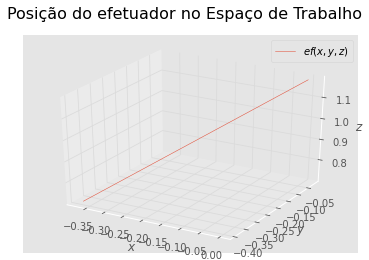

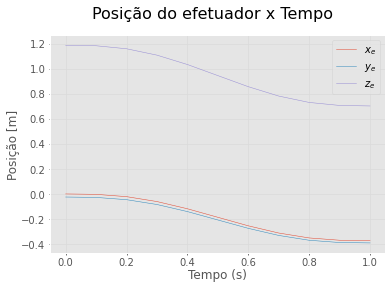

In [15]:
def plotar_trajetoria_cartesiano(x_t, Td, dt):
  
  start = 0
  step = dt
  end = Td+step
  t = np.arange(start,end,step)
  M = t.shape[0]

  # print(t)

  # Construir os gráficos

  fig = plt.figure()
  fig.suptitle('Posição do efetuador no Espaço de Trabalho',fontsize = 16)
  ax = plt.axes(projection='3d')
  ax.plot3D(x_t[:,0], x_t[:,1], x_t[:,2])
  ax.set_xlabel('$x$')
  ax.set_ylabel('$y$')
  ax.set_zlabel('$z$');
  ax.legend(["$ef(x,y,z)$"],loc = "upper right")


  lgn = ["$x_e$","$y_e$","$z_e$"]

  fig = plt.figure()
  fig.suptitle('Posição do efetuador x Tempo',fontsize = 16)
  ax1 = fig.add_subplot(1,1,1)
  for i in range(3):
    ax1.plot(t,x_t[:,i])
  ax1.grid(True)
  # ax1.legend(lgn,loc = "upper left",ncol=len(lgn))
  ax1.legend(lgn,loc = "upper right")
  plt.xlabel('Tempo (s)')
  plt.ylabel(r'Posição [m]')
  # https://matplotlib.org/3.5.0/tutorials/text/mathtext.html

  # fig = plt.figure() 
  # ax2 = fig.add_subplot(1,1,1)
  # for i in range(3):
  #   ax2.plot(t,w_efetuador[i,:])
  # ax2.grid(True)
  # ax2.legend(lgn_w,loc = "upper right")
  # plt.xlabel('Tempo (s)')
  # plt.ylabel(r'Velocidade angular $\omega$ [rad/s]')

# Testing the function
q_s = np.array([0,0,0,0,0,0,0]) # degrees
q_s = (pi/180)*q_s  # convert to rad
# q_g = np.array([90,90,0,-90,0,90,0])
q_g = np.array([100,55,120,82,30,-90,150]) # degrees
q_g = (pi/180)*q_g # convert to rad

Td = 1
dt = 0.1
robot1 = kinova_robot("KinovaGen3_P1")
[x_t, dx_t] = calcular_trajetoria_cartesiano(robot1,q_s,q_g,Td,dt)
plotar_trajetoria_cartesiano(x_t,Td,dt)

print("x_t = ",x_t)


### 5.2 Conversão de trajetória no espaço cartesiano para espaço das juntas

**Método 1:** uma das formas de converter uma trajetória no espaço cartesiano para o espaço das juntas é aplicar a cinemática inversa para todos os pontos da trajetória $\mathbf{x}(t)$. Entretanto, para o manipulador redundante, para uma dada posição do efetuador, existem múltiplas configurações possíveis (soluções válidas da cinemática inversa). Portanto, é preciso aplicar um método numérico iterativo que retorna, para um ponto da trajetória, a solução de configuração *mais próxima* da configuração associada ao ponto anterior da trajetória. Dessa forma, a continuidade do movimento das juntas é preservada.

**Método 2:** Uma outra forma de fazer isso é utilizar a pseudo-inversa do Jacobiano. Entretanto, esse método não é adequado quando a trajetória passa próximo de um ponto de singularidade. Próximo da singulariade, o valor da pseudo-inversa do Jacobinado é muito alto, o que resultaria em uma velocidade de juntas também muito alta. 

Nessa tarefa, você irá aplicar o **método 2** para converter a trajetória no espaço cartesiano para o espaço das juntas.

O número de condicionamento de um função (condition number) mede quanto o valor de saída é alterado por uma pequena variação na entrada. Aplicado a matriz, quando o determinante da matriz é zero, o número de condicionamento é infinito.

No método 2 para controle de trajetória de robôs manipuladores, deve-se evitar trajetórias que passam próximo de configurações singulares, onde o determinante da matriz Jacobiano é zero. Ao invés de verificar ao longo da trajetória o determinante do Jacobinao, iremos verificar o número de condicionamento que pode ser utilizado para matrizes não quadradas:

`c = np.linalg.cond(matriz)`

Se o número de condicionamento do Jacobiano de velocidade linear $cond(J_v)$ for menor que um limiar, ou seja, $cond(J_v) < J_{max}$, então o ponto está suficientemente longe da singularidade, e podemos calcular a pseudo-inversa $J_v^{-1}$. 

Então, para construir a trajetória no espaço das juntas:

$$ \mathbf{q}(0) = \mathbf{q_s}$$

Para $t = 0 \ldots (T_d-dt)$:

$$c_J(t) = cond(J_v(\mathbf{q}(t)))$$
$$\mathbf{\dot q}(t) = ({^0J_v}(\mathbf{q}(t)))^{-1} [{^0R_B} {^B\mathbf{\dot x}}(t)] $$
$$\delta \mathbf{q} = ({^0J_v}(\mathbf{q}(t)))^{-1} [{^0R_B}[\mathbf{x}(t+dt) - \mathbf{x}(t)]]$$
$$\mathbf{q}(t+dt) = \mathbf{q}(t) + \delta \mathbf{q}$$

Implementar a seguinte função de conversão que retorna uma matriz com as configurações do robô para cada instante de tempo. Não se preocupe, se a configuração final da trajetória não for a mesma que $q_g$. O importante é que a posição final do efetuador seja igual a posição final desejada.

<ins>Observação</ins>: cond(J) verifica o quão próximos estamos de uma singularidade. Próximos de uma singularidade, $J^{-1}$ não pode ser calculado, e precisaremos trocar de método (ou trocar a trajetória).

In [11]:
def trajetoria_cartesiano_para_juntas(robot,q_s, q_g, x_t, dx_t, Td, dt, J_min):
  HB0 = robot.base
  RB0 = HB0.R
  R0B = np.transpose(RB0)

  start = 0
  step = dt
  end = Td+step
  t = np.arange(start,end,step)
  M = t.shape[0]
  N = q_s.shape[0]

  q_t = np.zeros((M,N)) # Inicializando a matriz de saída
  
  q_t[0,:] = q_s

  for i in range(M-1):
    Jac = calcular_jacobiano(robot,q_t[i,:])
    Jac1 = robot.jacob0(q_t[i])

    # print("\nJac = \n",Jac,"\nJac1 = \n",Jac1)

    Jv = Jac[0:3,:] # Obtendo J das velocidades lineares, Jv
    
    c = np.linalg.cond(Jv)
    # print(c)

    if c < J_min:
      iJv = np.linalg.pinv(Jv)
      dx = x_t[i+1]-x_t[i] # Verificar
      R0Bdx = np.dot(R0B,dx)

      dq = np.dot(iJv,R0Bdx)
      q_t[i+1,:] = q_t[i,:] + dq

  return q_t

# Testing the function
q_s = np.array([0,10,20,30,40,50,60])*pi/180
q_g = np.array([10,20,30,40,50,60,70])*pi/180

# q_s = np.array([1,1,1,1,1,1,1]) # inicial
# q_g = np.array([0.75,0.75,0.75,0.75,0.75,0.75,0.75,]) # final

# q_s = np.array([0,0,0,0,0,0,0])*pi/180
# q_g = np.array([90,90,0,-90,0,90,0])*pi/180

Td = 0.9
dt = 0.1
robot1 = kinova_robot("KinovaGen3_P1")
[x_t, dx_t] = calcular_trajetoria_cartesiano(robot1,q_s,q_g,Td,dt)

J_min = 500 # Limiar para o número de condicionamento
q_t = trajetoria_cartesiano_para_juntas(robot1,q_s, q_g, x_t, dx_t, Td, dt, J_min)
# print("q_t = ",q_t*180/pi)

q_t =  [[ 0.         10.         20.         30.         40.         50.
  60.        ]
 [ 0.13382857 10.01569099 20.08432157 30.18731683 40.00107615 50.14195704
  60.        ]
 [ 0.88902765 10.11445841 20.56020577 31.23323088 40.00811193 50.9275672
  60.        ]
 [ 2.46866573 10.43740522 21.55536512 33.2957058  40.03366039 52.39728403
  60.        ]
 [ 4.74618953 11.2191192  22.97884995 35.93780136 40.09786257 54.06092264
  60.        ]
 [ 7.35087829 12.55762178 24.55812615 38.50223627 40.20426731 55.35030177
  60.        ]
 [ 9.77566326 14.19948728 25.94064604 40.47465921 40.32685046 56.02118953
  60.        ]
 [11.54447855 15.6237821  26.86934046 41.66028418 40.42692669 56.21033071
  60.        ]
 [12.41436737 16.39493528 27.2927679  42.157603   40.4789673  56.20911178
  60.        ]
 [12.56970349 16.5383122  27.36524968 42.23906815 40.48847164 56.20126125
  60.        ]]


###5.3 Plotar Resultado 

Para verificar se a trajetória controlada está correta, podemos converter a trajetória no espaço das juntas que foi resultado da funcão `trajetoria_cartesiano_para_juntas` em trajetória no espaço cartesiano, e plotar essa trajetória.

In [12]:
def plotar_trajetoria_cartesiano_resultado(robo, q_t, dt, Td):
  # Converter através da função 'pose_efetuador' a trajetoria no espaço das juntas para trajetória do efetuador no espaço cartesiano
  start = 0
  step = dt
  end = Td+step
  t = np.arange(start,end,step)
  M = t.shape[0]
  N = q_t.shape[1]

  HH = calcular_traj_efetuador(robo, q_t)

  xyz = HH[:,:,3] # Vetor de translação, falta tirar o elemento 1 na posição 4x4 de H
  x_t = xyz[:,0:3] # Agora está ok

  # Plotar a trajetória no espaço cartesiano usando a função 'plotar_trajetoria_cartesiano'
  plotar_trajetoria_cartesiano(x_t,Td,dt)


### 5.4 Teste as funções implementadas

Escolha uma configuração inicial $\mathbf{q_s}$ e final para o robô $\mathbf{q_g}$ de forma que não exista pontos de singularidade ao longo da trajetória reta entre as configuracões. Escolha também um valor de $T_d$ e $dt$.

Teste as funções implementadas em 5.1 e 5.2 para os valores escolhidos, e plote um gráfico com a trajetória 3D do efetuador no espaço cartesiano, e um gráfico com a trajetória no espaço das juntas do manipulador. 

q_t =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
x_t =  [[-1.88448649e-16 -2.46000000e-02  1.18730000e+00]
 [-3.72332987e-09 -2.46000037e-02  1.18730000e+00]
 [-2.97419443e-08 -2.46000292e-02  1.18729996e+00]
 ...
 [-3.72892053e-01 -3.91062894e-01  7.02510413e-01]
 [-3.72892079e-01 -3.91062919e-01  7.02510379e-01]
 [-3.72892082e-01 -3.91062923e-01  7.02510374e-01]]


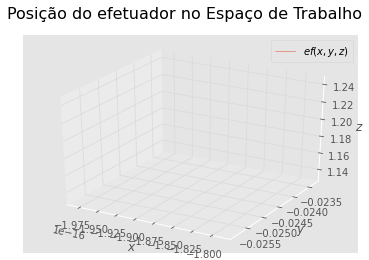

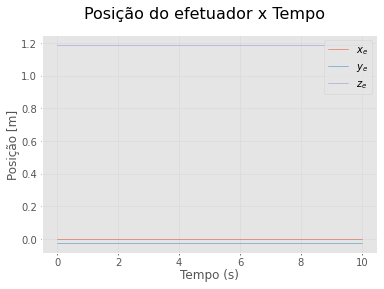

In [14]:
Td = 10.0
dt = 0.01
robot1 = kinova_robot("KinovaGen3_P1")
[x_t, dx_t] = calcular_trajetoria_cartesiano(robot1,q_s,q_g,Td,dt)
# q_s = np.array([0,10,20,30,40,50,60])*pi/180
# q_g = np.array([10,20,30,40,50,60,70])*pi/180

q_s = np.array([0,0,0,0,0,0,0]) # degrees
q_s = (pi/180)*q_s  # convert to rad
q_g = np.array([100,55,120,82,30,-90,150]) # degrees
q_g = (pi/180)*q_g # convert to rad

J_min = 100 # Limiar para o número de condicionamento
q_t = trajetoria_cartesiano_para_juntas(robot1,q_s, q_g, x_t, dx_t, Td, dt, J_min)

plotar_trajetoria_cartesiano_resultado(robot1, q_t, dt, Td)
print("q_t = ",q_t*180/pi)
print("x_t = ",x_t)